In [ ]:
pip install tensorflow scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Metric,Recall, Precision
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import os
import cv2
import random
from sklearn.metrics import jaccard_score, accuracy_score
from scipy.spatial.distance import directed_hausdorff
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score, roc_curve
from keras.metrics import Recall, Precision, AUC
from sklearn.utils import class_weight
from glob import glob
import tensorflow as tf

In [ ]:
# Define the path to your dataset
images_path = '/content/drive/MyDrive/images'
masks_path = '/content/drive/MyDrive/masks'

In [ ]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
def load_dataset(images_path, masks_path, split=0.2):
    images = sorted(glob(os.path.join(images_path, "*.png")))
    masks = sorted(glob(os.path.join(masks_path, "*.png")))

    # Verifing that every image has a corresponding mask
    image_filenames = [os.path.basename(img) for img in images]
    mask_filenames = [os.path.basename(msk) for msk in masks]

    # Identify and remove mismatched masks
    mismatched_masks = [msk for msk in mask_filenames if msk not in image_filenames]
    if mismatched_masks:
        print(f"Mismatched masks: {mismatched_masks}")
        masks = [msk for msk in masks if os.path.basename(msk) not in mismatched_masks]

    if len(images) != len(masks):
        raise ValueError("The number of images and masks do not match. Please ensure they are paired correctly.")

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split, random_state=672)
    train_y, valid_y = train_test_split(masks, test_size=split, random_state=672)

    test_size = int(split * len(train_x) / (1 - split))  # Corrected test size calculation
    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=672)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=672)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

batch_size = 16
lr = 1e-4
num_epochs = 20

# Change model_path extension to .keras
model_path = os.path.join("files", "model.keras")
csv_path = os.path.join("files", "log.csv")


In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(images_path, masks_path, split=0.2)

print(f"Train: ({len(train_x)}, {len(train_y)})")
print(f"Valid: ({len(valid_x)}, {len(valid_y)})")
print(f"Test: ({len(test_x)}, {len(test_y)})")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

Mismatched masks: ['2979 (1).png']
Train: (1839, 1839)
Valid: (613, 613)
Test: (612, 612)


In [ ]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def unet(input_shape):
    inputs = tf.keras.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.Model(inputs, outputs, name="UNET")
    return model

model = unet((H, W, 3))
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
for batch in train_dataset.take(1):
    images, masks = batch
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")

Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 1)


In [ ]:
# Ensure that the directory exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.CSVLogger(csv_path),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]

model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.Adam(lr), metrics=[dice_coef,'accuracy'])

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=1,  # Set verbose to 1 or 2 to display epochs details
)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6548 - dice_coef: 0.0841 - loss: 0.9159   
Epoch 1: val_loss improved from inf to 0.97862, saving model to files/model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.6561 - dice_coef: 0.0844 - loss: 0.9156 - val_accuracy: 0.5150 - val_dice_coef: 0.0213 - val_loss: 0.9786 - learning_rate: 1.0000e-04
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.9618 - dice_coef: 0.2044 - loss: 0.7956
Epoch 2: val_loss did not improve from 0.97862
115/115 ━━━━━━━━━━━━━━━━━━━━ 111s 953ms/step - accuracy: 0.9618 - dice_coef: 0.2045 - loss: 0.7955 - val_accuracy: 0.6728 - val_dice_coef: 0.0186 - val_loss: 0.9813 - learning_rate: 1.0000e-04
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.9762 - dice_coef: 0.2742 - loss: 0.7258
Epoch 3: val_loss improved from 0.97862 to 0.93803, saving model to files/model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 112s 971ms/step - accuracy: 0.9762 - dice_coef: 0

In [ ]:
# Define the directory where you want to save the model
save_dir = 'path_to_save_model/'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the model
model.save(os.path.join(save_dir, 'my_model.keras'))

In [ ]:
print(os.getcwd())

/content


In [ ]:
for batch in train_dataset.take(1):
    images, masks = batch
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")
    print(f"Image dtype: {images.dtype}")
    print(f"Mask dtype: {masks.dtype}")

Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 1)
Image dtype: <dtype: 'float32'>
Mask dtype: <dtype: 'float32'>


In [ ]:
# Evaluate on the validation dataset
print("Evaluating on the validation dataset...")
val_metrics = model.evaluate(valid_dataset, verbose=1)

# Evaluate on the test dataset
print("\nEvaluating on the test dataset...")
test_metrics = model.evaluate(test_dataset, verbose=1)

# Print out the validation metrics
print("\nValidation Metrics:")
for name, value in zip(model.metrics_names, val_metrics):
    print(f"{name}: {value:.4f}")

# Print out the test metrics
print("\nTest Metrics:")
for name, value in zip(model.metrics_names, test_metrics):
    print(f"{name}: {value:.4f}")


Evaluating on the validation dataset...
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.9927 - dice_coef: 0.7600 - loss: 0.2400

Evaluating on the test dataset...
39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9914 - dice_coef: 0.7298 - loss: 0.2703

Validation Metrics:
loss: 0.2439
compile_metrics: 0.7574

Test Metrics:
loss: 0.2737
compile_metrics: 0.7280


In [ ]:
# Make predictions on the validation dataset
val_preds = model.predict(valid_dataset)
val_preds_binary = (val_preds > 0.5).astype(int)  # Convert predictions to binary (0 or 1)

# Make predictions on the test dataset
test_preds = model.predict(test_dataset)
test_preds_binary = (test_preds > 0.5).astype(int)  # Convert predictions to binary (0 or 1)


39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 311ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step


In [ ]:


# Flatten the predictions and true labels for validation dataset
val_y_true = np.concatenate([y for x, y in valid_dataset], axis=0).flatten().astype(int)
val_y_pred = val_preds_binary.flatten()

# Flatten the predictions and true labels for test dataset
test_y_true = np.concatenate([y for x, y in test_dataset], axis=0).flatten().astype(int)
test_y_pred = test_preds_binary.flatten()


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

# Validation metrics
val_f1 = f1_score(val_y_true, val_y_pred)
val_precision = precision_score(val_y_true, val_y_pred)
val_recall = recall_score(val_y_true, val_y_pred)
val_auc = roc_auc_score(val_y_true, val_y_pred)
val_accuracy = accuracy_score(val_y_true, val_y_pred)

# Test metrics
test_f1 = f1_score(test_y_true, test_y_pred)
test_precision = precision_score(test_y_true, test_y_pred)
test_recall = recall_score(test_y_true, test_y_pred)
test_auc = roc_auc_score(test_y_true, test_y_pred)
test_accuracy = accuracy_score(test_y_true, test_y_pred)

# Print validation metrics
print("\nValidation Metrics:")
print(f"F1 Score: {val_f1:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"AUC: {val_auc:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")

# Print test metrics
print("\nTest Metrics:")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"AUC: {test_auc:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")



Validation Metrics:
F1 Score: 0.7796
Precision: 0.8555
Recall: 0.7161
AUC: 0.8571
Accuracy: 0.9937

Test Metrics:
F1 Score: 0.7496
Precision: 0.8465
Recall: 0.6726
AUC: 0.8352
Accuracy: 0.9924


In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
from glob import glob
from sklearn.model_selection import train_test_split


H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(images_path, masks_path, split=0.2):
    images = sorted(glob(os.path.join(images_path, "*.png")))
    masks = sorted(glob(os.path.join(masks_path, "*.png")))

    # Verify that every image has a corresponding mask
    image_filenames = [os.path.basename(img) for img in images]
    mask_filenames = [os.path.basename(msk) for msk in masks]

    # Identify and remove mismatched masks
    mismatched_masks = [msk for msk in mask_filenames if msk not in image_filenames]
    if mismatched_masks:
        print(f"Mismatched masks: {mismatched_masks}")
        masks = [msk for msk in masks if os.path.basename(msk) not in mismatched_masks]

    if len(images) != len(masks):
        raise ValueError("The number of images and masks do not match. Please ensure they are paired correctly.")

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split, random_state=42)

    test_size = int(split * len(train_x) / (1 - split))  # Corrected test size calculation
    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def data_augment(x, y):
    # Apply random 90 degree rotations
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    x = tf.image.rot90(x, k)
    y = tf.image.rot90(y, k)
    return x, y

def tf_dataset(X, Y, batch=32, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

batch_size = 16
lr = 1e-4
num_epochs = 20

# Change model_path extension to .keras
model_path = os.path.join("files", "model.keras")
csv_path = os.path.join("files", "log.csv")

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(images_path, masks_path, split=0.2)

print(f"Train: ({len(train_x)}, {len(train_y)})")
print(f"Valid: ({len(valid_x)}, {len(valid_y)})")
print(f"Test: ({len(test_x)}, {len(test_y)})")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size, augment=True)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def unet(input_shape):
    inputs = tf.keras.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.Model(inputs, outputs, name="UNET")
    return model

model = unet((H, W, 3))
model.summary()



Mismatched masks: ['2979 (1).png']
Train: (1839, 1839)
Valid: (613, 613)
Test: (612, 612)


Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 256, 256, 64)   │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 256, 256, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 128, 128, 128)  │            512 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 128, 128, 128)  │            512 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5      

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.CSVLogger(csv_path),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]

model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.Adam(lr), metrics=[dice_coef, 'accuracy'])

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7293 - dice_coef: 0.0944 - loss: 0.9056   
Epoch 1: val_loss improved from inf to 0.96294, saving model to files/model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.7302 - dice_coef: 0.0948 - loss: 0.9052 - val_accuracy: 0.5879 - val_dice_coef: 0.0369 - val_loss: 0.9629 - learning_rate: 1.0000e-04
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.9662 - dice_coef: 0.2498 - loss: 0.7502
Epoch 2: val_loss did not improve from 0.96294
115/115 ━━━━━━━━━━━━━━━━━━━━ 109s 932ms/step - accuracy: 0.9662 - dice_coef: 0.2500 - loss: 0.7500 - val_accuracy: 0.9778 - val_dice_coef: 0.0215 - val_loss: 0.9785 - learning_rate: 1.0000e-04
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.9770 - dice_coef: 0.3398 - loss: 0.6602
Epoch 3: val_loss improved from 0.96294 to 0.93917, saving model to files/model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 112s 969ms/step - accuracy: 0.9770 - dice_coef: 0

In [ ]:
# Make predictions on the test dataset
test_preds = model.predict(test_dataset)

39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 303ms/step


In [ ]:
# Convert probabilities to binary masks
threshold = 0.5
test_preds = (test_preds > threshold).astype(np.float32)

In [ ]:
def calculate_metrics(y_true, y_pred):
    dice = dice_coef(y_true, y_pred)
    accuracy = tf.keras.metrics.Accuracy()(y_true, y_pred)
    return dice, accuracy

# Get ground truth masks from the test dataset
y_true = []
for _, y in test_dataset:
    y_true.extend(y.numpy())
y_true = np.array(y_true)

# Calculate metrics
dice_score, accuracy = calculate_metrics(y_true, test_preds)

print(f"Dice Coefficient: {dice_score.numpy()}")
print(f"Accuracy: {accuracy.numpy()}")


Dice Coefficient: 0.73293137550354
Accuracy: 0.9911750555038452


In [ ]:
y_true = []
for _, y in test_dataset:
    y_true.extend(y.numpy())
y_true = np.array(y_true).flatten()

# Ensure y_true is binary
y_true = (y_true > threshold).astype(np.float32)

# 4. Flatten predictions for metric calculations
y_pred = test_preds.flatten()

# 5. Calculate Precision, Recall, F1 Score, and AUC
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")

Precision: 0.8332141162731287
Recall: 0.6541224131953896
F1 Score: 0.7328859577459589
AUC: 0.8259015761793006


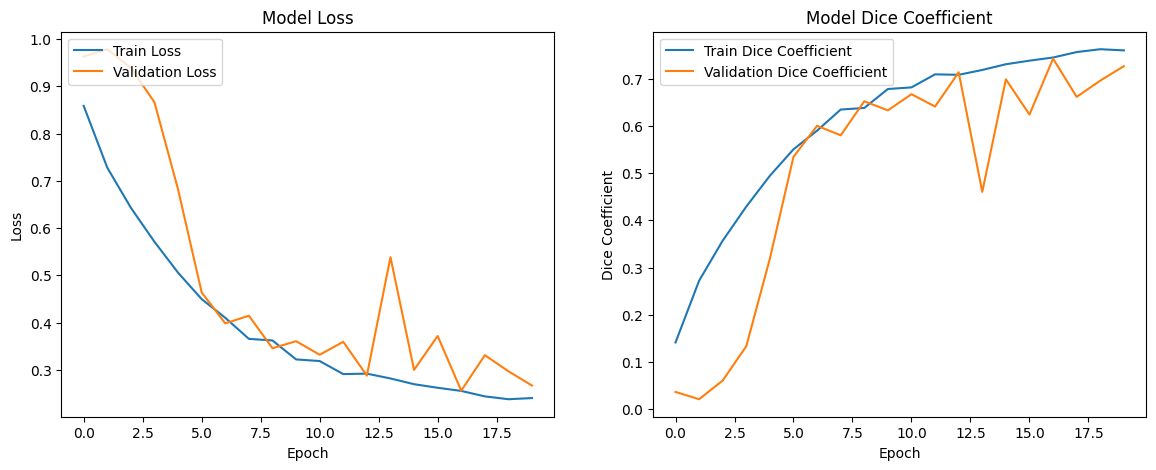

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the logged metrics from the CSV file
csv_path = os.path.join("files", "log.csv")
log_data = pd.read_csv(csv_path)

# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(log_data['epoch'], log_data['loss'], label='Train Loss')
plt.plot(log_data['epoch'], log_data['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation Dice coefficient values
plt.subplot(1, 2, 2)
plt.plot(log_data['epoch'], log_data['dice_coef'], label='Train Dice Coefficient')
plt.plot(log_data['epoch'], log_data['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Model Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_random_images(original_images, augmented_images, original_masks, augmented_masks, num_images=5):
    indices = np.random.choice(len(original_images), num_images, replace=False)

    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices):
        # Display original image
        plt.subplot(4, num_images, i + 1)
        plt.imshow(original_images[idx])
        plt.title("Original Image")
        plt.axis('off')

        # Display augmented image
        plt.subplot(4, num_images, i + 1 + num_images)
        plt.imshow(augmented_images[idx])
        plt.title("Augmented Image")
        plt.axis('off')

        # Display original mask
        plt.subplot(4, num_images, i + 1 + 2 * num_images)
        plt.imshow(original_masks[idx].squeeze(), cmap="gray")
        plt.title("Original Mask")
        plt.axis('off')

        # Display augmented mask
        plt.subplot(4, num_images, i + 1 + 3 * num_images)
        plt.imshow(augmented_masks[idx].squeeze(), cmap="gray")
        plt.title("Augmented Mask")
        plt.axis('off')

    plt.show()

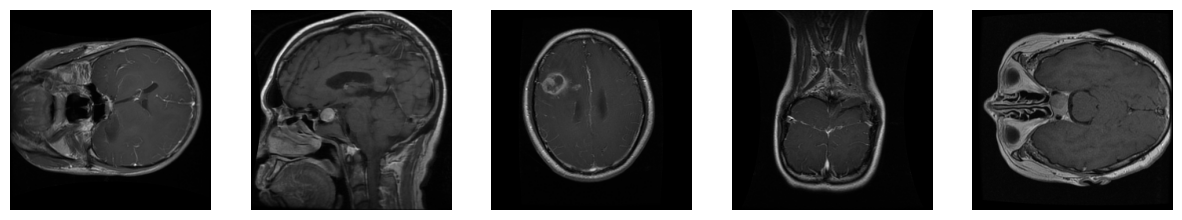

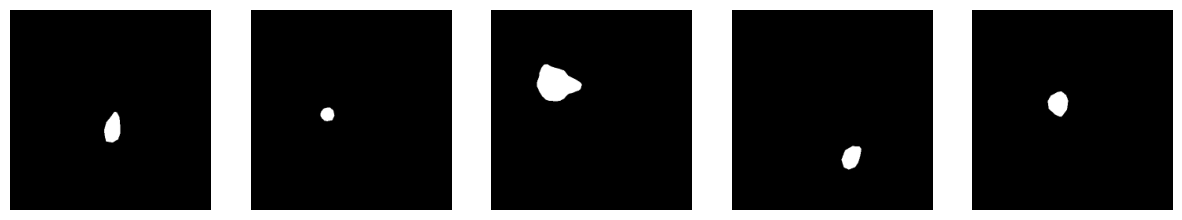

In [ ]:
# Fetch one batch of data from the augmented dataset
for images, masks in train_dataset.take(1):  # 'train_dataset' is augmented by default
    augmented_images = images.numpy()
    augmented_masks = masks.numpy()

    # Display the augmented images
    num_images_to_display = 5  # Number of images you want to display
    display_images(augmented_images[:num_images_to_display])
    display_images(augmented_masks[:num_images_to_display], cmap="gray")
    break

Original Images


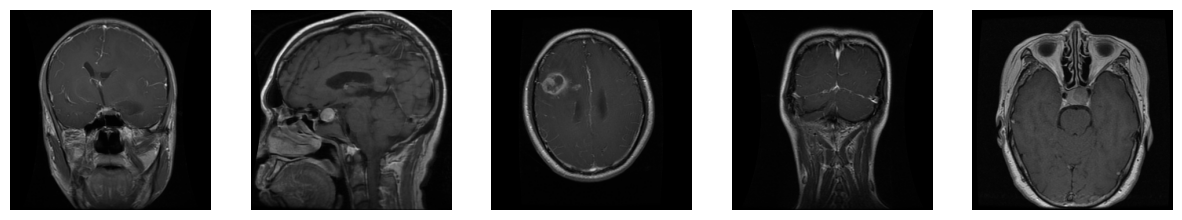

Augmented Images


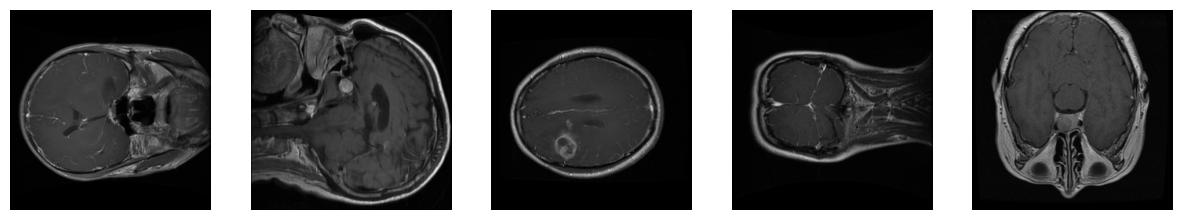

Original Masks


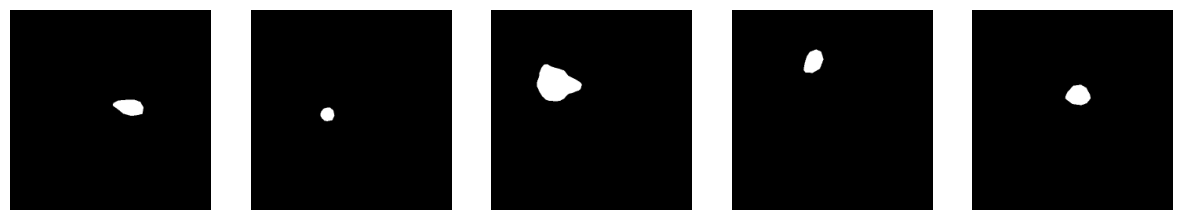

Augmented Masks


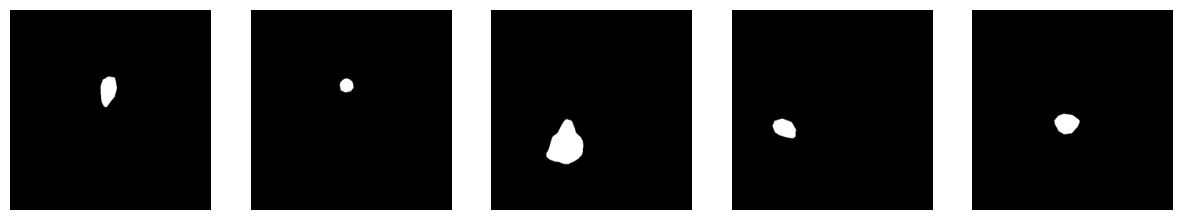

In [ ]:
# Fetch one batch of data from the original dataset without augmentation
for original_images, original_masks in tf_dataset(train_x, train_y, batch=batch_size, augment=False).take(1):
    original_images = original_images.numpy()
    original_masks = original_masks.numpy()
    break

# Fetch one batch of data from the augmented dataset
for augmented_images, augmented_masks in train_dataset.take(1):
    augmented_images = augmented_images.numpy()
    augmented_masks = augmented_masks.numpy()
    break

# Display original and augmented images side by side
num_images_to_display = 5  # Number of images you want to display

# Display Original Images
print("Original Images")
display_images(original_images[:num_images_to_display])

# Display Augmented Images
print("Augmented Images")
display_images(augmented_images[:num_images_to_display])

# Display Original Masks
print("Original Masks")
display_images(original_masks[:num_images_to_display], cmap="gray")

# Display Augmented Masks
print("Augmented Masks")
display_images(augmented_masks[:num_images_to_display], cmap="gray")


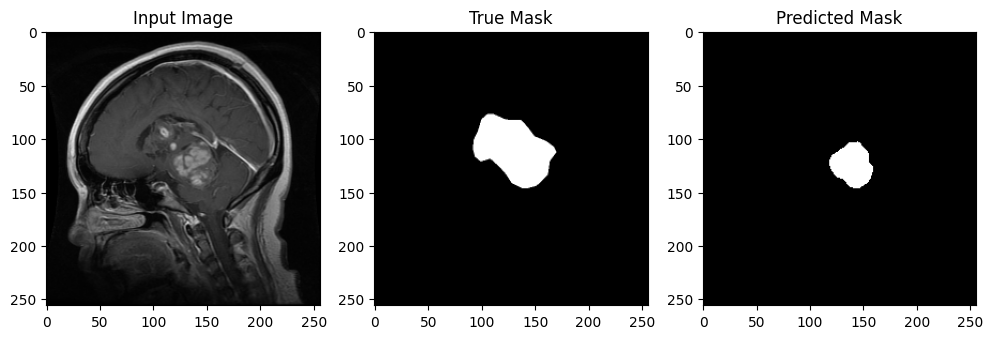

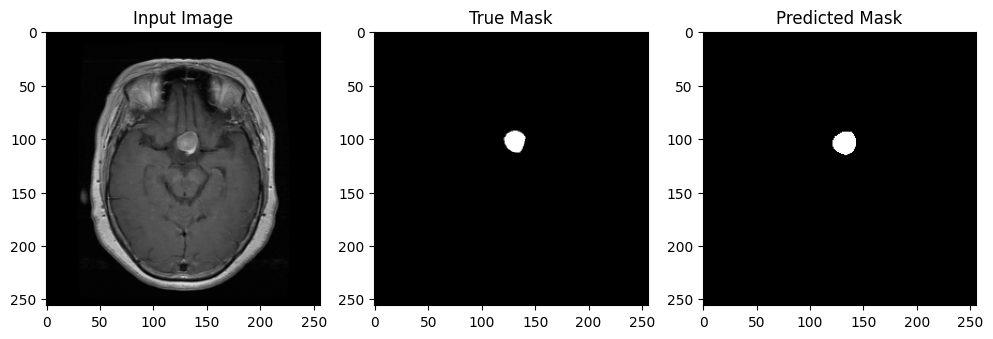

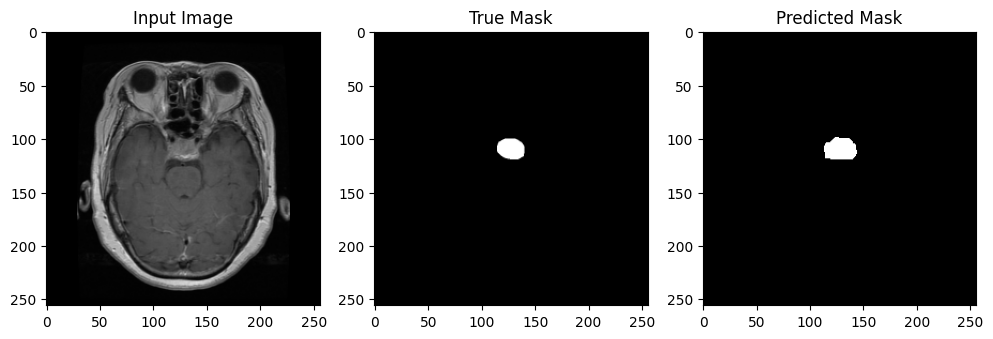

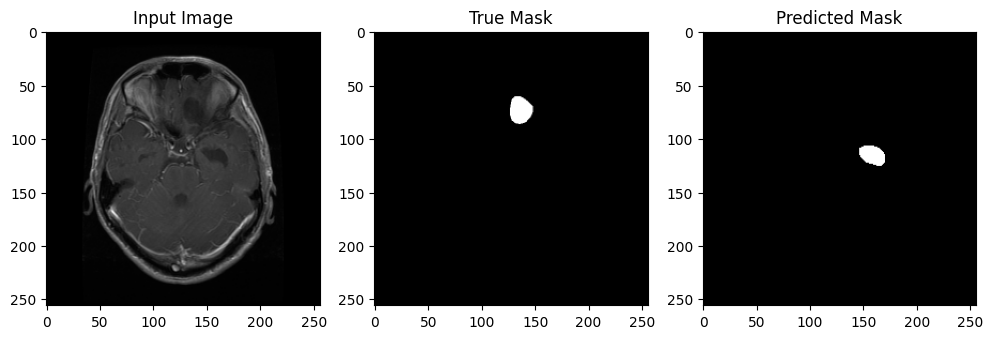

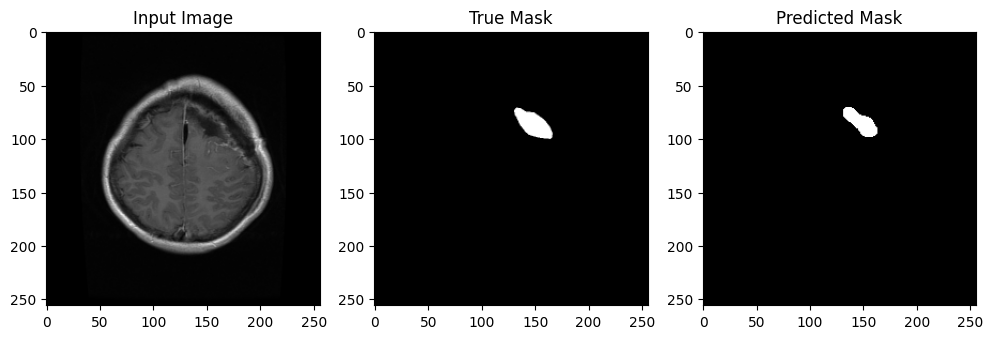

In [ ]:
import matplotlib.pyplot as plt

# Visualize a few predictions
def plot_sample(X, y_true, y_pred):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(X)

    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(y_true, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(y_pred, cmap='gray')

    plt.show()

# Iterate through some test samples and plot the results
for images, masks in test_dataset.take(1):
    for i in range(5):  # Plot 5 samples
        plot_sample(images[i], masks[i].numpy().squeeze(), test_preds[i].squeeze())


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import tensorflow as tf

# Define the number of folds
n_splits = 5

# Create KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare lists to store the metrics for each fold
precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []

# Convert image and mask paths to arrays
images = np.array(sorted(glob(os.path.join(images_path, "*.png"))))
masks = np.array(sorted(glob(os.path.join(masks_path, "*.png"))))


num_epochs = 10

# Cross-validation loop
for fold, (train_idx, valid_idx) in enumerate(kf.split(images)):
    print(f"Training fold {fold + 1}/{n_splits}...")

    # Create the training and validation sets for this fold
    train_images, train_masks = images[train_idx], masks[train_idx]
    valid_images, valid_masks = images[valid_idx], masks[valid_idx]

    # Create datasets for this fold
    train_dataset = tf_dataset(train_images, train_masks, batch=batch_size, augment=True)
    valid_dataset = tf_dataset(valid_images, valid_masks, batch=batch_size)

    # Define the model
    model = unet((H, W, 3))

    # Compile the model
    model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.Adam(lr), metrics=[dice_coef, 'accuracy'])

    # Train the model
    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate the model on the validation set
    valid_preds = model.predict(valid_dataset)
    valid_preds = (valid_preds > 0.5).astype(np.float32)  # Thresholding predictions

    # Flatten the ground truth and predictions
    y_true = []
    for _, y in valid_dataset:
        y_true.extend(y.numpy())
    y_true = np.array(y_true).flatten()
    y_true = (y_true > 0.5).astype(np.float32)  # Ensure y_true is binary

    y_pred = valid_preds.flatten()

    # Calculate metrics for this fold
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    # Store the metrics
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_scores.append(auc)

    print(f"Fold {fold + 1} - Precision: {precision}, Recall: {recall}, F1: {f1}, AUC: {auc}")

# Calculate the mean and standard deviation of the metrics across all folds
print("\nCross-Validation Results:")
print(f"Precision: {np.mean(precision_scores)} ± {np.std(precision_scores)}")
print(f"Recall: {np.mean(recall_scores)} ± {np.std(recall_scores)}")
print(f"F1 Score: {np.mean(f1_scores)} ± {np.std(f1_scores)}")
print(f"AUC: {np.mean(auc_scores)} ± {np.std(auc_scores)}")


Training fold 1/5...
Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8252 - dice_coef: 0.0955 - loss: 0.9045   
Epoch 1: val_loss did not improve from 0.25715
154/154 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8257 - dice_coef: 0.0958 - loss: 0.9042 - val_accuracy: 0.0329 - val_dice_coef: 0.0326 - val_loss: 0.9671 - learning_rate: 1.0000e-04
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.9635 - dice_coef: 0.2035 - loss: 0.7965
Epoch 2: val_loss did not improve from 0.25715
154/154 ━━━━━━━━━━━━━━━━━━━━ 133s 863ms/step - accuracy: 0.9635 - dice_coef: 0.2037 - loss: 0.7963 - val_accuracy: 0.2405 - val_dice_coef: 0.0371 - val_loss: 0.9626 - learning_rate: 1.0000e-04
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.9772 - dice_coef: 0.2727 - loss: 0.7273
Epoch 3: val_loss did not improve from 0.25715
154/154 ━━━━━━━━━━━━━━━━━━━━ 133s 860ms/step - accuracy: 0.9771 - dice_coef: 0.2728 - loss: 0.7272 - val_accuracy: 0.5013 - val_dic

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import tensorflow as tf


# Create datasets for the full training data
train_dataset = tf_dataset(images, masks, batch=batch_size, augment=True)

# Define and compile the final model
final_model = unet((H, W, 3))
final_model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.Adam(lr), metrics=[dice_coef, 'accuracy'])

# Train the final model on the entire dataset
final_model.fit(
    train_dataset,
    epochs=num_epochs,
    verbose=1
)

# Make predictions on the test dataset
final_test_preds = final_model.predict(test_dataset)
final_test_preds_binary = (final_test_preds > 0.5).astype(np.float32)  # Thresholding predictions

# Flatten predictions and ground truths for metric calculations
y_true = []
for _, y in test_dataset:
    y_true.extend(y.numpy())
y_true = np.array(y_true).flatten()

y_pred = final_test_preds_binary.flatten()

# Calculate metrics for the final model
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

print(f"Final Precision: {precision}")
print(f"Final Recall: {recall}")
print(f"Final F1 Score: {f1}")
print(f"Final AUC: {auc}")


ValueError: Dimensions 3064 and 3065 are not compatible

In [ ]:
pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy

# Set mixed precision policy
set_global_policy('mixed_float16')

def model_builder(hp):
    hp_filters = hp.Choice('num_filters', values=[16, 32, 64])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    inputs = tf.keras.Input((H, W, 3))
    s1, p1 = encoder_block(inputs, hp_filters)
    s2, p2 = encoder_block(p1, hp_filters * 2)
    s3, p3 = encoder_block(p2, hp_filters * 4)
    s4, p4 = encoder_block(p3, hp_filters * 8)
    b1 = conv_block(p4, hp_filters * 16)
    d1 = decoder_block(b1, s4, hp_filters * 8)
    d2 = decoder_block(d1, s3, hp_filters * 4)
    d3 = decoder_block(d2, s2, hp_filters * 2)
    d4 = decoder_block(d3, s1, hp_filters)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss=dice_loss,
                  metrics=[dice_coef, 'accuracy'])

    return model


In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=5,  # Reduce the number of trials
    executions_per_trial=1,
    directory='my_dir',
    project_name='unet_tuning'
)

Reloading Tuner from my_dir/unet_tuning/tuner0.json


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=8, augment=True)
valid_dataset = tf_dataset(valid_x, valid_y, batch=8)

In [ ]:
tuner.search(train_dataset, epochs=2, validation_data=valid_dataset)



Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
128               |32                |num_filters
0.0001            |0.001             |learning_rate

Epoch 1/2


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-39-eb3779237e91>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 234, in search

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 6722513560 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_564641]
